In [1]:
import os 
from dotenv import load_dotenv, find_dotenv
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import geoplot as gplt
import geopandas as gpd

%matplotlib inline

/home/vagrant/miniconda3/envs/ipykernel_py35/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


2/24/17

In this notebook I test doing some basic rollups of demographic data from ACS census tables (2010-2015 averages) by fire management area. In addition, I attempt to explore the capabilities of the geopandas and geoplot libraries for easy python-based static spatial mapping within a notebook.

**NOTE: geopandas currently requires a python 3.5 environment and is not available for windows**


One way to do this is in conda:

`$ conda create -n py35 python=3.5 geoplot`
    




In [2]:
# walk root diretory to find and load .env file w/ AWS host, username and password
load_dotenv(find_dotenv())

True

In [3]:
# connect to postgres
def pgconnect():
    try:
        conn = psycopg2.connect(database=os.environ.get("database"), user=os.environ.get("user"), 
                            password = os.environ.get("password"), 
                            host=os.environ.get("host"), port=os.environ.get("port"))
        print("Opened database successfully")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [4]:
def pquery(QUERY):
    '''
    takes SQL query string, opens a cursor, executes query in psql, and pulls results into pandas df
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)
        
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()


In [5]:
from geopandas import GeoSeries, GeoDataFrame

def gpd_query(QUERY):
    '''
    takes SQL query string, connects to postgres, and creates geopandas dataframe
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY+'\r\n')
        geo_df = GeoDataFrame.from_postgis(QUERY, 
        conn, geom_col='geom', crs={'init': u'epsg:4326'}, 
        coerce_float=False)
        
        print("created geopandas dataframe!")
        return geo_df
        
    except Exception as e:
        print(e.pgerror)
            
    finally:
        conn.close()


In [6]:
# get all rows from census block to fma lookup table 
QUERY1='''SELECT *
FROM fmac_proportion;
'''

In [7]:
df1 = pquery(QUERY1)

Opened database successfully
SQL QUERY = SELECT *
FROM fmac_proportion;



In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 4 columns):
c_block        770 non-null object
fma            770 non-null object
overlap_cbg    770 non-null float64
overlap_fma    770 non-null float64
dtypes: float64(2), object(2)
memory usage: 24.1+ KB


In [9]:
df1.head(10)

c_block fma  overlap_cbg   overlap_fma
0  410050201001  10     0.002468  7.874073e-04
1  410050203032  10     0.000015  7.926580e-07
2  410050203041  18     0.000056  4.442453e-06
3  410050208001  10     0.001001  2.550445e-04
4  410050208001  20     0.055454  1.285901e-02
5  410050209001  20     0.239613  8.783360e-03
6  410050210001  25     0.003061  1.808271e-04
7  410050210002  20     0.006363  6.558618e-04
8  410050210002  25     0.015021  1.445884e-03
9  410050212001  20     0.042128  4.428812e-03

Each row in this lookup table is an intersection of census block group (c_block) to Fire Management Area (fma). 

* overlap_cbg is the proprtion calculated by intersection area / total census block area

* overlap_fma is the proportion calculated by intersection area / total fma area



**Now I test some queries converting data by census block group to fma**

In [10]:
# try joining census total population by census block group to fma
# include fma geometry in query
QUERY2='''SELECT f.fma,
  CAST(round(sum(c.estimate_total*f.overlap_cbg)) AS INTEGER) AS fma_population_total, s.geom
FROM fmac_proportion f 
INNER JOIN census_total_population c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY fma_population_total DESC
'''

In [11]:
df2 = gpd_query(QUERY2)

Opened database successfully
SQL QUERY = SELECT f.fma,
  CAST(round(sum(c.estimate_total*f.overlap_cbg)) AS INTEGER) AS fma_population_total, s.geom
FROM fmac_proportion f 
INNER JOIN census_total_population c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY fma_population_total DESC


created geopandas dataframe!


In [12]:
df2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 3 columns):
fma                     31 non-null object
fma_population_total    31 non-null int64
geom                    31 non-null object
dtypes: int64(1), object(2)
memory usage: 824.0+ bytes


In [13]:
df2

fma  fma_population_total  \
0   07                 42544   
1   25                 41133   
2   14                 37634   
3   09                 34321   
4   11                 34236   
5   31                 31487   
6   19                 30588   
7   28                 28355   
8   18                 27347   
9   29                 24628   
10  13                 24159   
11  30                 23736   
12  03                 22086   
13  26                 21932   
14  20                 20305   
15  05                 17793   
16  04                 17533   
17  08                 17209   
18  24                 16678   
19  22                 16630   
20  12                 16281   
21  02                 15268   
22  23                 11746   
23  10                 10972   
24  15                  9552   
25  01                  7333   
26  27                  5548   
27  21                  4628   
28  17                  4021   
29  16                  4010   
30  06                  1908   

                                                 geom  
0   (POLYGON ((-122.53768848 45.49444708800007, -1...  
1   (POLYGON ((-122.5996791489999 45.4614523220000...  
2   (POLYGON ((-122.6452597909999 45.5482393280000...  
3   (POLYGON ((-122.618542734 45.49893638500004, -...  
4   (POLYGON ((-122.5648676069999 45.4598086640000...  
5   (POLYGON ((-122.487770149 45.48629978200006, -...  
6   (POLYGON ((-122.581914988 45.50345943100007, -...  
7   (POLYGON ((-122.628283273 45.52984537400005, -...  
8   (POLYGON ((-122.733431708 45.43437200000005, -...  
9   (POLYGON ((-122.532502628 45.46131735600005, -...  
10  (POLYGON ((-122.641449046 45.52287213300008, -...  
11  (POLYGON ((-122.495851838 45.53367824700007, -...  
12  (POLYGON ((-122.687297627 45.51911160700007, -...  
13  (POLYGON ((-122.697516128 45.57713450100005, -...  
14  (POLYGON ((-122.647196584 45.43698371300007, -...  
15  (POLYGON ((-122.744500398 45.47635703600008, -...  
16  (POLYGON ((-122.667871984 45.49139775000003, -...  
17  (POLYGON ((-122.659356838 45.57443762700007, -...  
18  (POLYGON ((-122.678595213 45.54187543200004, -...  
19  (POLYGON ((-122.749928676 45.56111859500004, -...  
20  (POLYGON ((-122.5613547139999 45.5481082460000...  
21  (POLYGON ((-122.55780558 45.55178617400003, -1...  
22  (POLYGON ((-122.635609433 45.50195285100006, -...  
23  (POLYGON ((-122.669351416 45.43576608800004, -...  
24  (POLYGON ((-122.697179467 45.49952276100004, -...  
25  (POLYGON ((-122.654647701 45.52077605700003, -...  
26  (POLYGON ((-122.759578855 45.52367615000003, -...  
27  (POLYGON ((-122.647567292 45.51790209300003, -...  
28  (POLYGON ((-122.6413174309999 45.6005505050000...  
29  (POLYGON ((-122.734354547 45.49077355500003, -...  
30  (POLYGON ((-122.685554985 45.54041087700006, -...

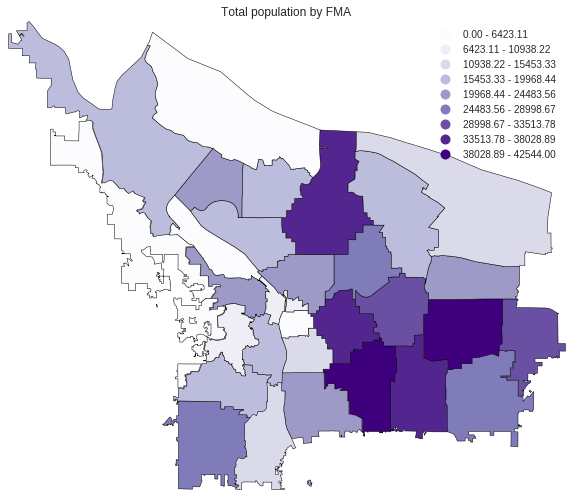

In [14]:
# map of population by fma
import geoplot.crs as gcrs # allow different projections

gplt.choropleth(df2,
                hue=df2['fma_population_total'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='Purples',
                linewidth=0.5,
                k=9,
                legend=True,
                scheme='equal_interval',
                figsize=(10, 10))

plt.title("Total population by FMA")

In [15]:
# try joining census housing_tenure by census block group to fma
QUERY3='''SELECT f.fma,
  CAST(round(sum(c.estimate_total_households*f.overlap_cbg)) AS INTEGER) AS total_households,
  CAST(round(sum(c.estimate_total_owner_occupied*f.overlap_cbg)) AS INTEGER) AS total_owner_occupied,
  (sum(c.estimate_total_owner_occupied*f.overlap_cbg))/(sum(c.estimate_total_households*f.overlap_cbg))
  AS percent_owner_occupied,
  CAST(round(sum(c.estimate_total_renter_occupied*f.overlap_cbg)) AS INTEGER) AS total_renter_occupied,
  (sum(c.estimate_total_renter_occupied*f.overlap_cbg)/sum(c.estimate_total_households*f.overlap_cbg))
    AS percent_renter_occupied,
  s.geom
FROM fmac_proportion f INNER JOIN census_housing_tenure c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY total_households DESC
'''

In [16]:
df3 = gpd_query(QUERY3)

Opened database successfully
SQL QUERY = SELECT f.fma,
  CAST(round(sum(c.estimate_total_households*f.overlap_cbg)) AS INTEGER) AS total_households,
  CAST(round(sum(c.estimate_total_owner_occupied*f.overlap_cbg)) AS INTEGER) AS total_owner_occupied,
  (sum(c.estimate_total_owner_occupied*f.overlap_cbg))/(sum(c.estimate_total_households*f.overlap_cbg))
  AS percent_owner_occupied,
  CAST(round(sum(c.estimate_total_renter_occupied*f.overlap_cbg)) AS INTEGER) AS total_renter_occupied,
  (sum(c.estimate_total_renter_occupied*f.overlap_cbg)/sum(c.estimate_total_households*f.overlap_cbg))
    AS percent_renter_occupied,
  s.geom
FROM fmac_proportion f INNER JOIN census_housing_tenure c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY total_households DESC


created geopandas dataframe!


In [17]:
df3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
fma                        31 non-null object
total_households           31 non-null int64
total_owner_occupied       31 non-null int64
percent_owner_occupied     31 non-null float64
total_renter_occupied      31 non-null int64
percent_renter_occupied    31 non-null float64
geom                       31 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 1.8+ KB


In [18]:
df3

fma  total_households  total_owner_occupied  percent_owner_occupied  \
0   25             17263                  9648                0.558886   
1   09             15456                  8071                0.522185   
2   07             14879                  6141                0.412705   
3   14             14326                  9551                0.666703   
4   03             14052                  3640                0.259041   
5   19             12574                  6989                0.555833   
6   11             12245                  6399                0.522552   
7   28             11831                  7678                0.648990   
8   18             11570                  7581                0.655211   
9   13             11457                  4717                0.411670   
10  31             10189                  5311                0.521216   
11  04             10015                  2472                0.246847   
12  30              8969                  5495                0.612598   
13  20              8474                  5440                0.641916   
14  29              7960                  4951                0.621909   
15  05              7641                  4844                0.634019   
16  08              7113                  4352                0.611765   
17  26              7094                  4090                0.576595   
18  22              6989                  4220                0.603739   
19  24              6751                  3279                0.485676   
20  12              6274                  4001                0.637783   
21  02              5894                  3406                0.577888   
22  23              5159                  2305                0.446883   
23  15              4763                  2395                0.502917   
24  01              4706                  1010                0.214561   
25  10              4629                  3044                0.657551   
26  21              2515                   464                0.184363   
27  27              2059                  1646                0.799331   
28  17              1947                  1578                0.810286   
29  16              1735                  1217                0.701563   
30  06               918                   425                0.462344   

    total_renter_occupied  percent_renter_occupied  \
0                    7615                 0.441114   
1                    7385                 0.477815   
2                    8738                 0.587295   
3                    4775                 0.333297   
4                   10412                 0.740959   
5                    5585                 0.444167   
6                    5847                 0.477448   
7                    4153                 0.351010   
8                    3989                 0.344789   
9                    6741                 0.588330   
10                   4879                 0.478784   
11                   7543                 0.753153   
12                   3475                 0.387402   
13                   3034                 0.358084   
14                   3010                 0.378091   
15                   2796                 0.365981   
16                   2762                 0.388235   
17                   3003                 0.423405   
18                   2770                 0.396261   
19                   3472                 0.514324   
20                   2272                 0.362217   
21                   2488                 0.422112   
22                   2853                 0.553117   
23                   2368                 0.497083   
24                   3696                 0.785439   
25                   1585                 0.342449   
26                   2051                 0.815637   
27                    413                 0.200669   
28                    369                 0.189714   
29            

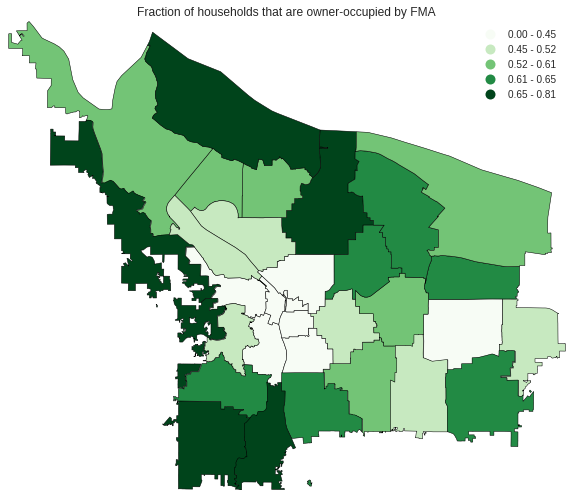

In [19]:
gplt.choropleth(df3,
                hue=df3['percent_owner_occupied'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='Greens',
                linewidth=0.5,
                #k=9,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of households that are owner-occupied by FMA")

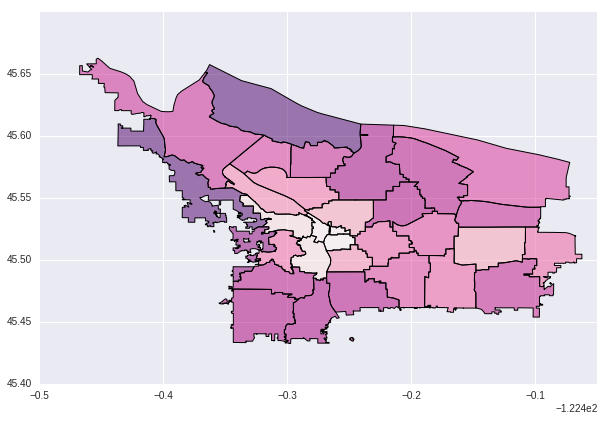

In [22]:
# choropleth map of FMA by percent owner occupied using matplotlib
# NOTE: I had to remove the legend to prevent matplotlib from throwing an error from scaling based on a float number
df3.plot(column='percent_owner_occupied', cmap= 'RdPu',figsize=(10,10))

In [23]:
# try joining census estimate_median_household_income by census block group to fma
# note this is not a statistically valid query since we can't simply apply a weighted average to medians
# but it's at least one approach to approximate a median for fmas

QUERY4='''SELECT f.fma,
  round(sum(c.estimate_median_household_income*f.overlap_fma)) AS median_household_income,
  s.geom
FROM fmac_proportion f 
  INNER JOIN census_median_household_income c
  ON f.c_block = c.id2
  INNER JOIN fma_shapes s
  ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY median_household_income DESC
'''

In [24]:
df4 = gpd_query(QUERY4)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.estimate_median_household_income*f.overlap_fma)) AS median_household_income,
  s.geom
FROM fmac_proportion f 
  INNER JOIN census_median_household_income c
  ON f.c_block = c.id2
  INNER JOIN fma_shapes s
  ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY median_household_income DESC


created geopandas dataframe!


In [25]:
#df4.info()

In [26]:
df4

fma  median_household_income  \
0   27                 137883.0   
1   16                 130537.0   
2   15                 117597.0   
3   10                 108234.0   
4   05                  90861.0   
5   03                  90696.0   
6   06                  84673.0   
7   18                  81527.0   
8   22                  72752.0   
9   09                  71971.0   
10  28                  70605.0   
11  20                  69572.0   
12  04                  64823.0   
13  13                  64694.0   
14  23                  60260.0   
15  02                  58055.0   
16  14                  57180.0   
17  29                  56955.0   
18  25                  56630.0   
19  30                  54654.0   
20  19                  54614.0   
21  08                  54371.0   
22  17                  53353.0   
23  26                  53298.0   
24  31                  44065.0   
25  11                  41935.0   
26  12                  40524.0   
27  07                  38163.0   
28  24                  32925.0   
29  21                  32174.0   
30  01                  32171.0   

                                                 geom  
0   (POLYGON ((-122.759578855 45.52367615000003, -...  
1   (POLYGON ((-122.734354547 45.49077355500003, -...  
2   (POLYGON ((-122.697179467 45.49952276100004, -...  
3   (POLYGON ((-122.669351416 45.43576608800004, -...  
4   (POLYGON ((-122.744500398 45.47635703600008, -...  
5   (POLYGON ((-122.687297627 45.51911160700007, -...  
6   (POLYGON ((-122.685554985 45.54041087700006, -...  
7   (POLYGON ((-122.733431708 45.43437200000005, -...  
8   (POLYGON ((-122.749928676 45.56111859500004, -...  
9   (POLYGON ((-122.618542734 45.49893638500004, -...  
10  (POLYGON ((-122.628283273 45.52984537400005, -...  
11  (POLYGON ((-122.647196584 45.43698371300007, -...  
12  (POLYGON ((-122.667871984 45.49139775000003, -...  
13  (POLYGON ((-122.641449046 45.52287213300008, -...  
14  (POLYGON ((-122.635609433 45.50195285100006, -...  
15  (POLYGON ((-122.55780558 45.55178617400003, -1...  
16  (POLYGON ((-122.6452597909999 45.5482393280000...  
17  (POLYGON ((-122.532502628 45.46131735600005, -...  
18  (POLYGON ((-122.5996791489999 45.4614523220000...  
19  (POLYGON ((-122.495851838 45.53367824700007, -...  
20  (POLYGON ((-122.581914988 45.50345943100007, -...  
21  (POLYGON ((-122.659356838 45.57443762700007, -...  
22  (POLYGON ((-122.6413174309999 45.6005505050000...  
23  (POLYGON ((-122.697516128 45.57713450100005, -...  
24  (POLYGON ((-122.487770149 45.48629978200006, -...  
25  (POLYGON ((-122.5648676069999 45.4598086640000...  
26  (POLYGON ((-122.5613547139999 45.5481082460000...  
27  (POLYGON ((-122.53768848 45.49444708800007, -1...  
28  (POLYGON ((-122.678595213 45.54187543200004, -...  
29  (POLYGON ((-122.647567292 45.51790209300003, -...  
30  (POLYGON ((-122.654647701 45.52077605700003, -...

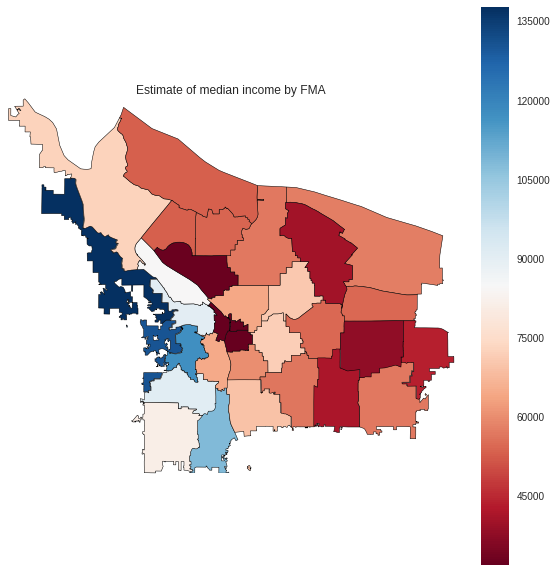

In [27]:
gplt.choropleth(df4,
                hue=df4['median_household_income'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='RdBu',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Estimate of median income by FMA")

In the choropleth map above, I chose to use a diverging colormap to better highlight differences in the estimate of median income by FMA.One can see that the FMAs to the West side of te Williamette River tend to have higher estimated household median income. The lowest estimate FMAs occur in central close-in Eastside and then closer to the Eastern edge of PF&R's territory. 

In [28]:
# explore health insurance status by FMA
QUERY6='''SELECT f.fma,
  round(sum(c.with_health_insurance*f.overlap_fma)) AS with_health_insurance,
  ((sum(c.with_health_insurance*f.overlap_cbg))/(sum(c.with_health_insurance*f.overlap_cbg)
      +(sum(c.no_health_insurance*f.overlap_cbg)))) AS percent_with_health_insurance,
  round(sum(c.no_health_insurance*f.overlap_fma)) AS no_health_insurance,
  ((sum(c.no_health_insurance*f.overlap_cbg))/(sum(c.with_health_insurance*f.overlap_cbg)
      +(sum(c.no_health_insurance*f.overlap_cbg)))) AS percent_no_health_insurance,
  s.geom    
FROM fmac_proportion f INNER JOIN census_health_insurance c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_no_health_insurance DESC
'''

In [29]:
df6 = gpd_query(QUERY6)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.with_health_insurance*f.overlap_fma)) AS with_health_insurance,
  ((sum(c.with_health_insurance*f.overlap_cbg))/(sum(c.with_health_insurance*f.overlap_cbg)
      +(sum(c.no_health_insurance*f.overlap_cbg)))) AS percent_with_health_insurance,
  round(sum(c.no_health_insurance*f.overlap_fma)) AS no_health_insurance,
  ((sum(c.no_health_insurance*f.overlap_cbg))/(sum(c.with_health_insurance*f.overlap_cbg)
      +(sum(c.no_health_insurance*f.overlap_cbg)))) AS percent_no_health_insurance,
  s.geom    
FROM fmac_proportion f INNER JOIN census_health_insurance c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_no_health_insurance DESC


created geopandas dataframe!


In [30]:
df6.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 6 columns):
fma                              31 non-null object
with_health_insurance            31 non-null float64
percent_with_health_insurance    31 non-null float64
no_health_insurance              31 non-null float64
percent_no_health_insurance      31 non-null float64
geom                             31 non-null object
dtypes: float64(4), object(2)
memory usage: 1.5+ KB


In [31]:
df6

fma  with_health_insurance  percent_with_health_insurance  \
0   21                  894.0                       0.871431   
1   07                 2123.0                       0.892322   
2   23                  979.0                       0.892609   
3   29                 2772.0                       0.894004   
4   31                 1970.0                       0.896326   
5   24                  548.0                       0.901578   
6   01                 1309.0                       0.904346   
7   26                 1788.0                       0.905223   
8   11                 1667.0                       0.905835   
9   25                 1140.0                       0.907645   
10  19                 1148.0                       0.911454   
11  02                 1586.0                       0.920817   
12  03                 1754.0                       0.923769   
13  08                 1769.0                       0.924087   
14  13                  910.0                       0.925981   
15  04                 1437.0                       0.926227   
16  30                 1633.0                       0.926684   
17  14                 1064.0                       0.928727   
18  09                 1115.0                       0.931579   
19  22                 1552.0                       0.934268   
20  28                 1227.0                       0.937017   
21  12                  800.0                       0.937055   
22  05                 1468.0                       0.938842   
23  17                 2224.0                       0.941233   
24  18                 1904.0                       0.945108   
25  06                 1156.0                       0.946042   
26  15                 1213.0                       0.946814   
27  20                 1072.0                       0.952518   
28  10                 1874.0                       0.959377   
29  16                 1448.0                       0.967305   
30  27                 1810.0                       0.983622   

    no_health_insurance  percent_no_health_insurance  \
0                 132.0                     0.128569   
1                 246.0                     0.107678   
2                 104.0                     0.107391   
3                 268.0                     0.105996   
4                 205.0                     0.103674   
5                  51.0                     0.098422   
6                 138.0                     0.095654   
7                 166.0                     0.094777   
8                 158.0                     0.094165   
9                 110.0                     0.092355   
10                105.0                     0.088546   
11                 94.0                     0.079183   
12                 93.0                     0.076231   
13                137.0                     0.075913   
14                 83.0                     0.074019   
15                 95.0                     0.073773   
16                124.0                     0.073316   
17                 92.0                     0.071273   
18                 77.0                     0.068421   
19                 99.0                     0.065732   
20                 95.0                     0.062983   
21                 72.0                     0.062945   
22                 87.0                     0.061158   
23                162.0                     0.058767   
24                 92.0                     0.054892   
25                 52.0                     0.053958   
26                 43.0                     0.053186   
27                 48.0                     0.047482   
28                 63.0                     0.040623   
29                 45.0                     0.032695   
30                 44.0                     0.016378   

                                                 geom  
0   (POLYGON ((-122.647567292 45.51790209300003, -...  
1   (POLYGON ((-122.53768848 45.49444708800007, -

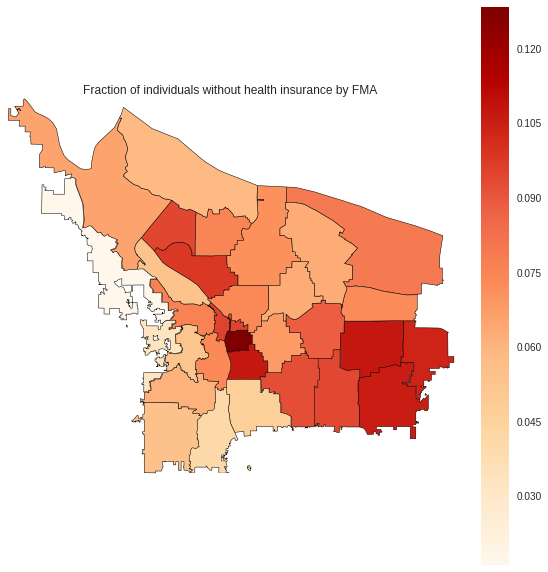

In [33]:
gplt.choropleth(df6,
                hue=df6['percent_no_health_insurance'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of individuals without health insurance by FMA")

In [34]:
# explore educational attainment by FMA
# aggregate by calculating % of individuals with college degree, % with postgraduate professional degree

QUERY7= '''SELECT f.fma,
  round(sum(c.bachelor_degree*f.overlap_fma)) AS college_grad,
  ((sum(c.bachelor_degree*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_colllege_grad,
  (((sum(c.bachelor_degree*f.overlap_cbg))
  +(sum(c.master_degree*f.overlap_cbg))
  +(sum(c.professional_school_degree*f.overlap_cbg))
  +(sum(c.doctorate_degree*f.overlap_cbg)))) AS college_grad_or_higher,   
  (((sum(c.bachelor_degree*f.overlap_cbg))
  +(sum(c.master_degree*f.overlap_cbg))
  +(sum(c.professional_school_degree*f.overlap_cbg))
  +(sum(c.doctorate_degree*f.overlap_cbg)))
  /(sum(c.total*f.overlap_cbg))) AS percent_college_grad_or_higher,
  s.geom   
FROM fmac_proportion f INNER JOIN census_educational_attainment c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_college_grad_or_higher DESC
'''

In [35]:
df7 = gpd_query(QUERY7)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.bachelor_degree*f.overlap_fma)) AS college_grad,
  ((sum(c.bachelor_degree*f.overlap_cbg))/(sum(c.total*f.overlap_cbg)
      )) AS percent_colllege_grad,
  (((sum(c.bachelor_degree*f.overlap_cbg))
  +(sum(c.master_degree*f.overlap_cbg))
  +(sum(c.professional_school_degree*f.overlap_cbg))
  +(sum(c.doctorate_degree*f.overlap_cbg)))) AS college_grad_or_higher,   
  (((sum(c.bachelor_degree*f.overlap_cbg))
  +(sum(c.master_degree*f.overlap_cbg))
  +(sum(c.professional_school_degree*f.overlap_cbg))
  +(sum(c.doctorate_degree*f.overlap_cbg)))
  /(sum(c.total*f.overlap_cbg))) AS percent_college_grad_or_higher,
  s.geom   
FROM fmac_proportion f INNER JOIN census_educational_attainment c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY percent_college_grad_or_higher DESC


created geopandas dataframe!


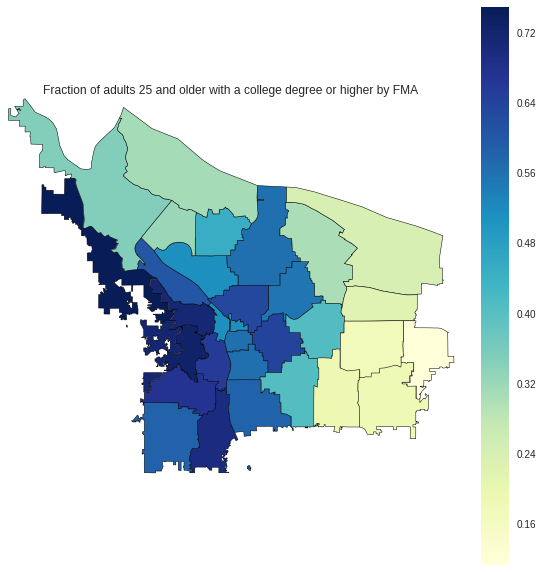

In [36]:
gplt.choropleth(df7,
                hue=df7['percent_college_grad_or_higher'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='YlGnBu',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of adults 25 and older with a college degree or higher by FMA")

In [37]:
# explore food stamps by FMA
QUERY8 = '''SELECT f.fma,
  round(sum(c.total*f.overlap_fma)) AS total,
  round(sum(c.hh_rec_fs*f.overlap_fma)) AS rec_food_stamps,
  ((sum(c.hh_rec_fs*f.overlap_fma))/(sum(c.total*f.overlap_cbg)
      )) AS percent_rec_fs,
  round(sum(c.hh_dn_rec_fs*f.overlap_fma)) AS dn_red_food_stamps,
  ((sum(c.hh_dn_rec_fs*f.overlap_fma))/(sum(c.total*f.overlap_cbg)
      )) AS percent_dn_rec_fs,
  s.geom   
FROM fmac_proportion f INNER JOIN census_food_stamps c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY rec_food_stamps DESC
'''

In [38]:
df8 = gpd_query(QUERY8)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.total*f.overlap_fma)) AS total,
  round(sum(c.hh_rec_fs*f.overlap_fma)) AS rec_food_stamps,
  ((sum(c.hh_rec_fs*f.overlap_fma))/(sum(c.total*f.overlap_cbg)
      )) AS percent_rec_fs,
  round(sum(c.hh_dn_rec_fs*f.overlap_fma)) AS dn_red_food_stamps,
  ((sum(c.hh_dn_rec_fs*f.overlap_fma))/(sum(c.total*f.overlap_cbg)
      )) AS percent_dn_rec_fs,
  s.geom   
FROM fmac_proportion f INNER JOIN census_food_stamps c
ON f.c_block = c.id2
INNER JOIN fma_shapes s
ON f.fma = s.fma
GROUP BY f.fma, s.geom
ORDER BY rec_food_stamps DESC


created geopandas dataframe!


In [39]:
df8

fma   total  rec_food_stamps  percent_rec_fs  dn_red_food_stamps  \
0   01   985.0            299.0        0.063473               687.0   
1   07   837.0            296.0        0.019874               541.0   
2   31   711.0            239.0        0.023460               472.0   
3   17   946.0            218.0        0.111822               728.0   
4   11   650.0            199.0        0.016280               451.0   
5   29   985.0            196.0        0.024635               789.0   
6   26   612.0            153.0        0.021636               459.0   
7   08   730.0            152.0        0.021425               578.0   
8   21   550.0            148.0        0.058778               403.0   
9   30   663.0            137.0        0.015300               526.0   
10  22   693.0            116.0        0.016618               577.0   
11  04   916.0            101.0        0.010048               815.0   
12  25   513.0            100.0        0.005790               413.0   
13  19   519.0             99.0        0.007878               420.0   
14  03  1026.0             99.0        0.007074               926.0   
15  23   482.0             99.0        0.019097               384.0   
16  28   557.0             93.0        0.007891               463.0   
17  13   500.0             92.0        0.007988               408.0   
18  14   420.0             88.0        0.006149               332.0   
19  12   317.0             84.0        0.013415               233.0   
20  05   671.0             72.0        0.009482               598.0   
21  18   837.0             67.0        0.005820               770.0   
22  09   532.0             58.0        0.003748               474.0   
23  06   548.0             56.0        0.061050               492.0   
24  20   453.0             53.0        0.006213               400.0   
25  02   685.0             43.0        0.007329               642.0   
26  24   227.0             42.0        0.006207               185.0   
27  16   633.0             31.0        0.018065               601.0   
28  15   573.0             30.0        0.006250               543.0   
29  27   692.0             27.0        0.013024               666.0   
30  10   725.0             25.0        0.005431               700.0   

    percent_dn_rec_fs                                               geom  
0            0.145932  (POLYGON ((-122.654647701 45.52077605700003, -...  
1            0.036349  (POLYGON ((-122.53768848 45.49444708800007, -1...  
2            0.046282  (POLYGON ((-122.487770149 45.48629978200006, -...  
3            0.373938  (POLYGON ((-122.6413174309999 45.6005505050000...  
4            0.036825  (POLYGON ((-122.5648676069999 45.4598086640000...  
5            0.099121  (POLYGON ((-122.532502628 45.46131735600005, -...  
6            0.064642  (POLYGON ((-122.697516128 45.57713450100005, -...  
7            0.081230  (POLYGON ((-122.659356838 45.57443762700007, -...  
8            0.160096  (POLYGON ((-122.647567292 45.51790209300003, -...  
9            0.058648  (POLYGON ((-122.495851838 45.53367824700007, -...  
10           0.082595  (POLYGON ((-122.749928676 45.56111859500004, -...  
11           0.081386  (POLYGON ((-122.667871984 45.49139775000003, -...  
12           0.023933  (POLYGON ((-122.5996791489999 45.4614523220000...  
13           0.033431  (POLYGON ((-122.581914988 45.50345943100007, -...  
14           0.065917  (POLYGON ((-122.687297627 45.51911160700007, -...  
15           0.074413  (POLYGON ((-122.635609433 45.50195285100006, -...  
16           0.039146  (POLYGON ((-122.628283273 45.52984537400005, -...  
17           0.035652  (POLYGON ((-122.641449046 45.52287213300008, -...  
18           0.023140  (POLYGON ((-122.6452597909999 45.5482393280000...  
19           0.037187  (POLYGON ((-122.5613547139999 45.5481082460000...  
20           0.078295  (POLYGON ((-122.744500398 45.47635703600008, -...  
21           0.066556  (POLYGON ((-122.733431708 45.43437200000005, -...  
22   

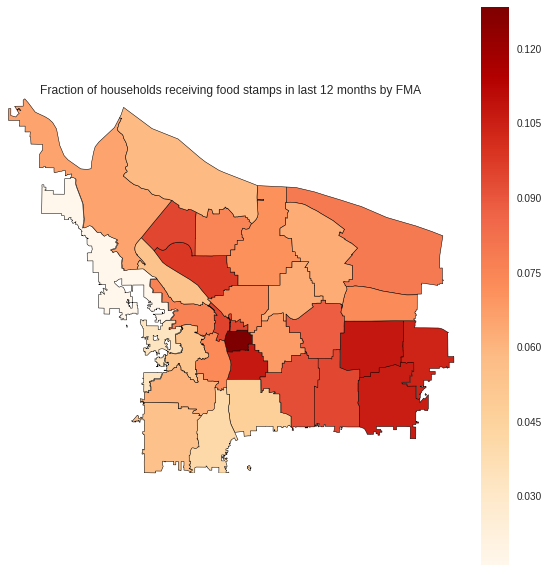

In [40]:
gplt.choropleth(df6,
                hue=df6['percent_no_health_insurance'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Fraction of households receiving food stamps in last 12 months by FMA")

In [41]:
# 

In [42]:
# try joining census_household_income by census block group to fma to look at income distribution

QUERY5='''SELECT f.fma,
  round(sum(c.total_less_than_10000*f.overlap_fma)) AS less_than_10000,
  round(sum(c.total_10000_to_14999*f.overlap_fma)) AS fr_10000_to_14999,
  round(sum(c.total_15000_to_19999*f.overlap_fma)) AS fr_15000_to_19999,
  round(sum(c.total_20000_to_24999*f.overlap_fma)) AS fr_20000_to_24999,
  round(sum(c.total_25000_to_29999*f.overlap_fma)) AS fr_25000_to_29999,
  round(sum(c.total_30000_to_34999*f.overlap_fma)) AS fr_30000_to_34999,
  round(sum(c.total_35000_to_39999*f.overlap_fma)) AS fr_35000_to_39999,
  round(sum(c.total_40000_to_44999*f.overlap_fma)) AS fr_40000_to_44999,
  round(sum(c.total_45000_to_49999*f.overlap_fma)) AS fr_45000_to_49999,
  round(sum(c.total_50000_to_59999*f.overlap_fma)) AS fr_50000_to_59999,
  round(sum(c.total_60000_to_74999*f.overlap_fma)) AS fr_60000_to_74999,
  round(sum(c.total_75000_to_99999*f.overlap_fma)) AS fr_75000_to_99999,
  round(sum(c.total_100000_to_124999*f.overlap_fma)) AS fr_100000_to_124999,
  round(sum(c.total_125000_to_149999*f.overlap_fma)) AS fr_125000_to_149999,
  round(sum(c.total_150000_to_199999*f.overlap_fma)) AS fr_150000_to_199999,
  round(sum(c.total_200000_or_more*f.overlap_fma)) AS fr_200000_or_more
FROM fmac_proportion f INNER JOIN census_household_income c
ON f.c_block = c.id2
GROUP BY f.fma
ORDER BY f.fma
'''

In [43]:
df5 = pquery(QUERY5)

Opened database successfully
SQL QUERY = SELECT f.fma,
  round(sum(c.total_less_than_10000*f.overlap_fma)) AS less_than_10000,
  round(sum(c.total_10000_to_14999*f.overlap_fma)) AS fr_10000_to_14999,
  round(sum(c.total_15000_to_19999*f.overlap_fma)) AS fr_15000_to_19999,
  round(sum(c.total_20000_to_24999*f.overlap_fma)) AS fr_20000_to_24999,
  round(sum(c.total_25000_to_29999*f.overlap_fma)) AS fr_25000_to_29999,
  round(sum(c.total_30000_to_34999*f.overlap_fma)) AS fr_30000_to_34999,
  round(sum(c.total_35000_to_39999*f.overlap_fma)) AS fr_35000_to_39999,
  round(sum(c.total_40000_to_44999*f.overlap_fma)) AS fr_40000_to_44999,
  round(sum(c.total_45000_to_49999*f.overlap_fma)) AS fr_45000_to_49999,
  round(sum(c.total_50000_to_59999*f.overlap_fma)) AS fr_50000_to_59999,
  round(sum(c.total_60000_to_74999*f.overlap_fma)) AS fr_60000_to_74999,
  round(sum(c.total_75000_to_99999*f.overlap_fma)) AS fr_75000_to_99999,
  round(sum(c.total_100000_to_124999*f.overlap_fma)) AS fr_100000_to_1

In [44]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 17 columns):
fma                    31 non-null object
less_than_10000        31 non-null float64
fr_10000_to_14999      31 non-null float64
fr_15000_to_19999      31 non-null float64
fr_20000_to_24999      31 non-null float64
fr_25000_to_29999      31 non-null float64
fr_30000_to_34999      31 non-null float64
fr_35000_to_39999      31 non-null float64
fr_40000_to_44999      31 non-null float64
fr_45000_to_49999      31 non-null float64
fr_50000_to_59999      31 non-null float64
fr_60000_to_74999      31 non-null float64
fr_75000_to_99999      31 non-null float64
fr_100000_to_124999    31 non-null float64
fr_125000_to_149999    31 non-null float64
fr_150000_to_199999    31 non-null float64
fr_200000_or_more      31 non-null float64
dtypes: float64(16), object(1)
memory usage: 4.2+ KB


In [45]:
df5

fma  less_than_10000  fr_10000_to_14999  fr_15000_to_19999  \
0   01            181.0              108.0               52.0   
1   02             25.0               18.0               12.0   
2   03             74.0               43.0               30.0   
3   04            106.0               36.0               33.0   
4   05             37.0               21.0               25.0   
5   06             20.0                6.0               13.0   
6   07             87.0               67.0               73.0   
7   08             41.0               21.0               49.0   
8   09             31.0               18.0               22.0   
9   10             28.0                9.0               18.0   
10  11             73.0               48.0               34.0   
11  12             20.0               24.0               29.0   
12  13             54.0               22.0               26.0   
13  14             22.0               24.0               20.0   
14  15             36.0               13.0               16.0   
15  16             33.0               15.0               12.0   
16  17             46.0               25.0               75.0   
17  18             34.0               29.0               29.0   
18  19             41.0               25.0               26.0   
19  20             25.0               19.0               13.0   
20  21            104.0               49.0               33.0   
21  22             57.0               15.0               35.0   
22  23             41.0               21.0               26.0   
23  24             20.0               14.0               10.0   
24  25             34.0               25.0               27.0   
25  26             54.0               25.0               34.0   
26  27             23.0                4.0                4.0   
27  28             26.0               28.0               24.0   
28  29             61.0               26.0               37.0   
29  30             48.0               39.0               37.0   
30  31             64.0               52.0               52.0   

    fr_20000_to_24999  fr_25000_to_29999  fr_30000_to_34999  \
0                73.0               48.0               29.0   
1                 6.0               18.0               21.0   
2                35.0               34.0               32.0   
3                23.0               49.0               52.0   
4                20.0               28.0               31.0   
5                16.0                8.0               20.0   
6                60.0               52.0               56.0   
7                19.0               62.0               37.0   
8                24.0               25.0               26.0   
9                15.0               15.0               18.0   
10               30.0               37.0               52.0   
11               12.0               25.0               19.0   
12               25.0               33.0               17.0   
13               10.0               26.0               20.0   
14               20.0               12.0               17.0   
15               36.0                6.0               19.0   
16               40.0               84.0               38.0   
17               18.0               38.0               38.0   
18               25.0               32.0               23.0   
19               11.0               19.0               25.0   
20               52.0               25.0               33.0   
21               21.0               40.0               30.0   
22               16.0               30.0               19.0   
23                9.0                8.0                7.0   
24               29.0               26.0               22.0   
25               18.0               40.0               24.0   
26               11.0                7.0               13.0   
27               23.0               23.0               31.0   
28               30.0               72.0               30.0   
29               41.0           

/home/vagrant/miniconda3/envs/ipykernel_py35/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


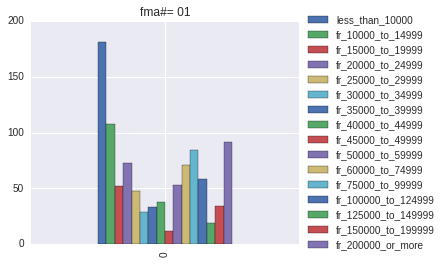

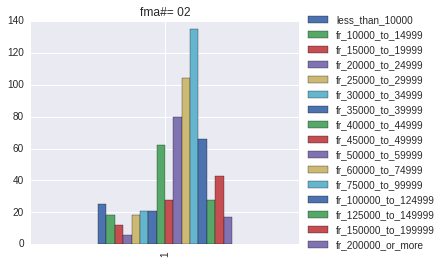

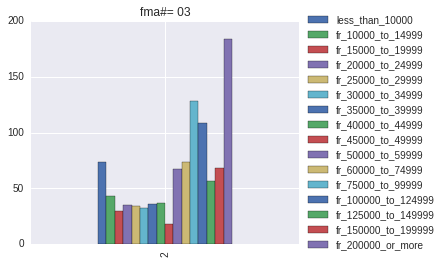

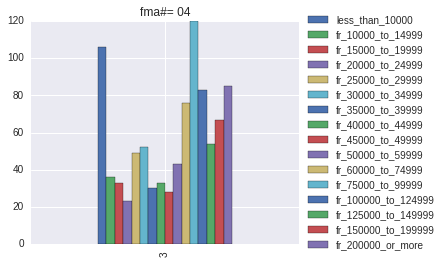

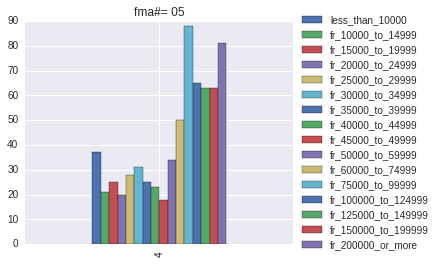

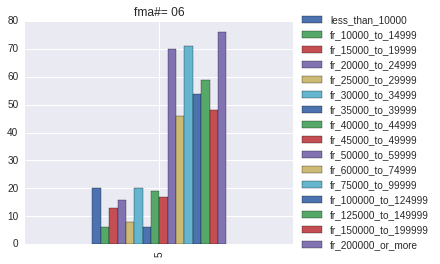

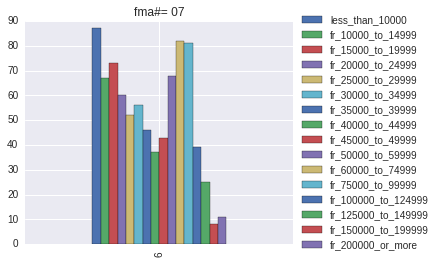

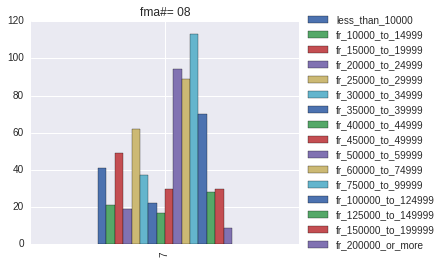

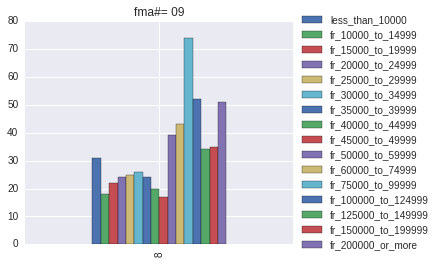

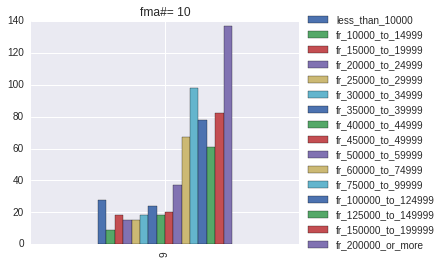

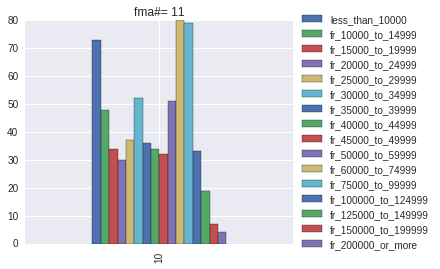

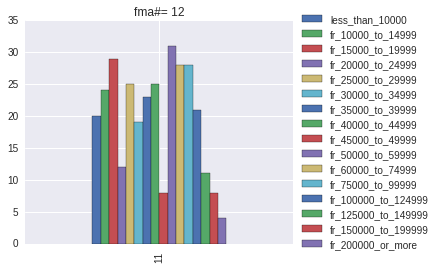

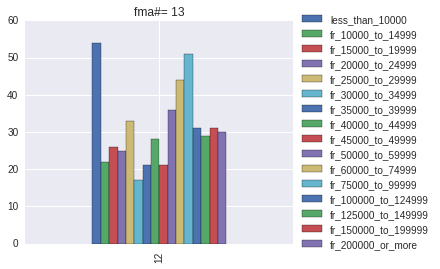

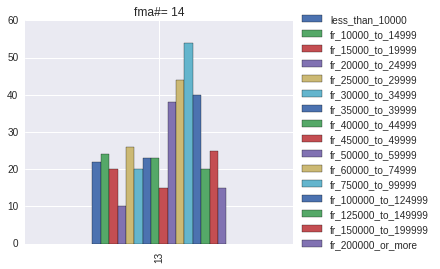

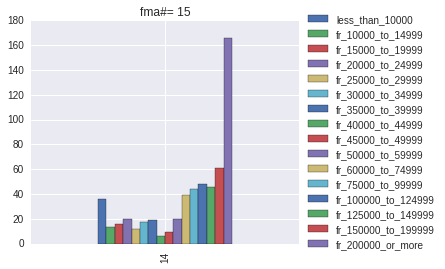

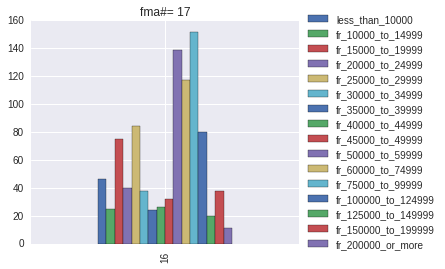

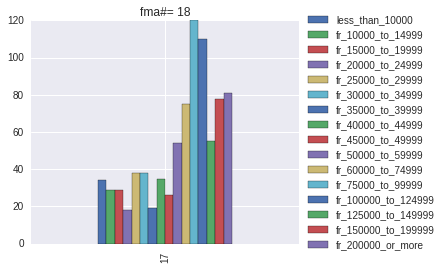

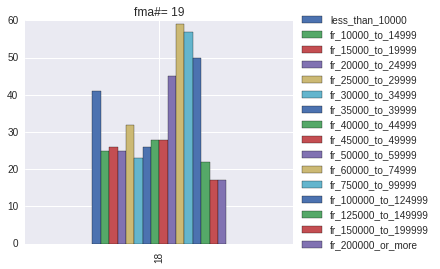

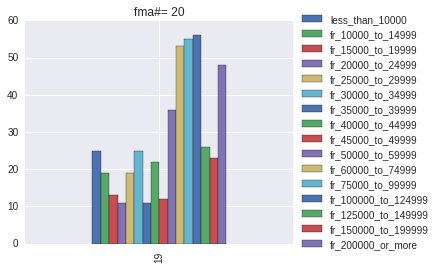

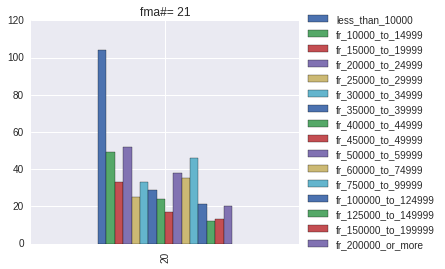

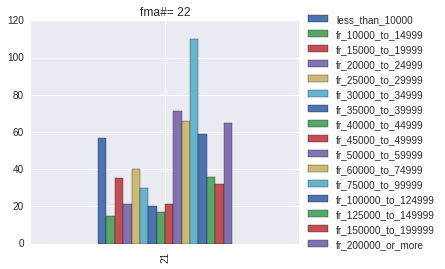

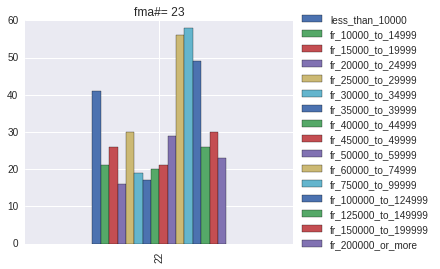

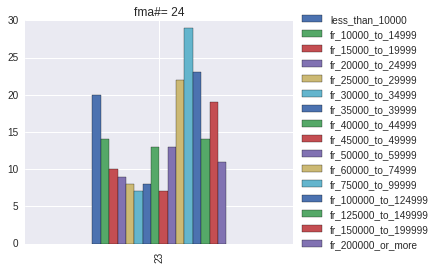

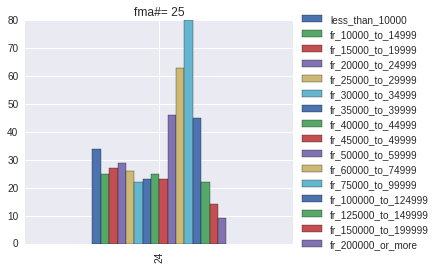

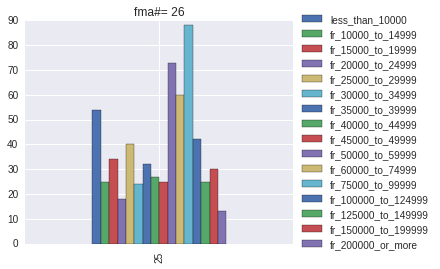

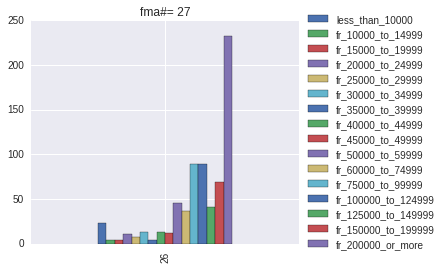

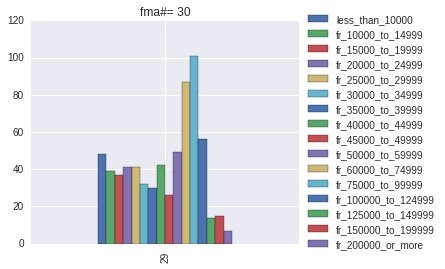

In [46]:
for i in df5['fma']:
    df5.loc[df5['fma'] == i,'less_than_10000':].plot(kind = 'bar',title = "fma#= "+str(i))
    # Shrink current axis by 20%
    ax = plt.subplot(111)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
            